# Tutorial 4: MBHBs & MCMC

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

In the fourth tutorial we will examine MBHB waveforms. We will examine how to generate waveforms, add the LISA response, calculate the Likelihood, and then we will run an MCMC with MBHBs. 

## Task 1: Generate IMRPhenomHM waveforms IMR = Inspiral Merger Ringdown. 

We will start by generating IMRPhenomHM waveforms for MBHBs. Pick reasonable parameters, build a waveform and plot it against the LISA Sensitivity Curve (`LISASens`) in the characteristic strain representation. **Hint**: set `f_ref = 0.0`. You can access the information after waveform generation as attributes on the class. This may be updated

IMRPhenomD is a quadrupole-only frequencydomain phenomenological waveform model describing inspiral-merger-ringdown (IMR) stages of aligned-spin BBH systems. IMRPhenomHM is a frequency domain **aligned-spin** phenomenological waveform model, wherein results from PostNewtonian theory (for inspiral) and BH perturbation theory (for ringdown) are used to map the dominant quadrupole mode to the sub-dominant modes. https://arxiv.org/pdf/1909.10010 

Useful documentation:
* [PhenomHMAmpPhase](https://mikekatz04.github.io/BBHx/html/user/waveforms.html#bbhx.waveforms.phenomhm.PhenomHMAmpPhase)

In [3]:
# imports 
from lisatools.sensitivity import get_sensitivity
from bbhx.waveforms.phenomhm import PhenomHMAmpPhase

No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.


In [4]:
wave_gen = PhenomHMAmpPhase()

# PhenomHMAmpPhase by itself generates PhenomHM waveforms in the amplitude and phase representation WITHOUT LISA RESPONSE!
# LISA reponse = AET channels =  what we see in the detector. This is what we care about. This is added in BBHWaveformFD
# BBHWaveformFD also uses PhenomHMAmpPhase to generate the waveforms, but it also adds the LISA response.

m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
f_ref = 0.0 # Hz            # let phenom codes set f_ref -> fmax = max(f^2A(f))
phi_ref = 0.0               # phase at f_ref
t_ref = 1e6 # seconds
length = 1024               # THIS WAS SO CONFUSING BECAUSE I DIDN'T READ THE DOCUMENTATION PROPERLY (See comments in the BBHWaveformFD cell)

wave_gen(m1, m2, chi1, chi2, dist, phi_ref, f_ref, t_ref, length)

# The output is (6, 1024) = 6 modes x 1024 length.
print(wave_gen.freqs_shaped[0].shape)

(6, 1024)


(1, 6, 1024) (10000,)


/var/folders/zq/6x2qbk397t13zwgl047mwbkm0000gn/T/ipykernel_92399/2774505748.py:7: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.loglog(wave_gen.freqs_shaped[0, i], char_strain, label=mode)


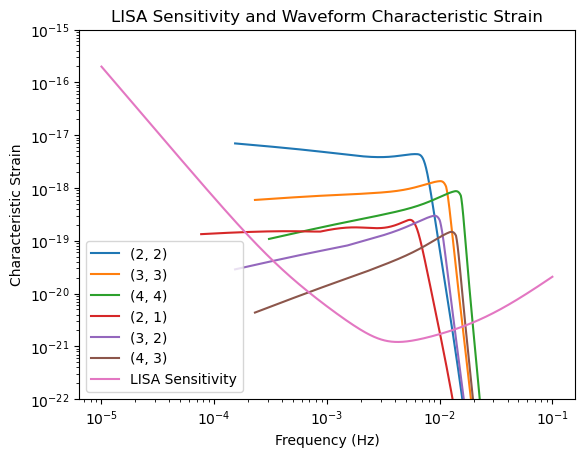

In [5]:
fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="LISASens", return_type="char_strain") 

modes = [(2,2), (3, 3), (4, 4), (2, 1), (3, 2), (4, 3)]
for i, mode in enumerate(modes):
    char_strain = wave_gen.freqs_shaped[0, i] * wave_gen.amp[0, i]
    plt.loglog(wave_gen.freqs_shaped[0, i], char_strain, label=mode)

plt.loglog(fn, Sn_char_strain, label="LISA Sensitivity")
plt.legend()
plt.title("LISA Sensitivity and Waveform Characteristic Strain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.ylim(1e-22, 1e-15)

print(wave_gen.freqs_shaped.shape, fn.shape)

## Task 2: Add the response. 

Now repeat the same task as above by adding the response. In `BBHx`, the response is added automatically for you using the main waveform production class: `BBHWaveformFD`. The sensitivity for this should be `A1TDISens`.

Useful Documentation:
* [BBHWaveformFD](https://mikekatz04.github.io/BBHx/html/user/main.html#bbhx.waveformbuild.BBHWaveformFD)

## Full TDI Waveforms

TDI observable waveforms are produced in three main parts:

1. Produce a waveform in the frequency-domain amplitude $(A(f))$ and phase $(\phi(f))$ representation at the solar system barycenter (SSB). This also must include the time-frequency correspondence. This is done by PhenomHMAmpPhase. This gives:

   $$
   \tilde{h}_{lm}(f) = A_{lm}(f) e^{-i\phi(f)}.
   $$

2. Use the time frequency correspondence to compute the LISA response transfer functions: $\mathcal{T}(f, t_{lm}(f))$, where $t_{lm}(f)$ is the time-frequency correspondence.

3. $A(f)$, $\phi(f)$, and $\mathcal{T}(f, t_{lm}(f))$ are computed on the same sparse grid in frequencies. The final step is interpolating to the frequencies of the Fourier transform of the data stream, producing the TDI observables $AET$:

   $$
   \tilde{h}^{AET}(f) = \sum_{lm} \mathcal{T}^{AET}(f, t_{lm}(f)) \tilde{h}_{lm}(f).
   $$


In [6]:
from bbhx.waveformbuild import BBHWaveformFD

No CuPy
No CuPy or GPU response available.


In [7]:
tdi_wave_gen = BBHWaveformFD()

m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
inc = np.pi / 8
lam = 3.4
beta = -0.7
psi = np.pi/4
t_ref = 1e6 # seconds

length = 1024
# length = Number of frequencies to use in sparse array for interpolation.

# setup data holders
Tobs = YRSID_SI / 12.  # 1 month
dt = 10.0  # sec
N = int(Tobs / dt)
Tobs = N * dt

freqs = np.fft.rfftfreq(N, dt)
# freqs argument in BBHWaveformFD = Frequencies at which to evaluate the final waveform. If length is also given, the interpolants interpolate to these frequencies.
# this is why the interpolation thing is important. check the shape of 

AET = tdi_wave_gen(
    m1,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    length=1024, 
    combine=False,  # TODO: check this
    direct=False,
    fill=True,
    squeeze=True,
    freqs=freqs   
)

# From my understanding, since freqs is given, the length of the output is the same as the length of freqs. 
# But the waveform itself is calculated at the number of frequencies given by length. In our case length = 1024 and len(freqs) = 131493
# For example, if length = 10, freqs = (0,100), and the waveform exists between 40 and 60, the output is calculated at only 10 frequencies between 40 and 60 (40, 42,.. 60).
# And I think the remaining frequencies in between are interpolated but I'm not sure. Need to check this.
# For the frequencies outside (40,60), the output is set to 0... I think. This is why for, say, AET[0,0], the output is zero for most starting frequencies.

In [8]:
print(AET.shape, freqs.shape, AET[0,0])

(1, 3, 131493) (131493,) [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j ...  1.90265685e-33-1.30391344e-32j
 -1.02793824e-32+8.23723689e-33j  1.31311998e-32+9.83920041e-34j]


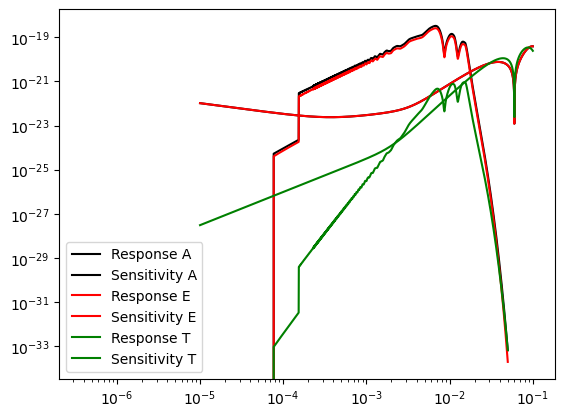

In [9]:
fn = np.logspace(-5, -1, 10000)
colours = ["black", "red", "green"]

#Response generated by BBHWaveformFD
for i, channel in enumerate(["A1TDISens", "E1TDISens", "T1TDISens"]):
    plt.loglog(freqs, freqs * np.abs(AET[0,i]), label="Response "+ channel[0], color=colours[i])
    plt.loglog(fn, get_sensitivity(fn, sens_fn=channel, return_type="char_strain"), label="Sensitivity "+ channel[0], color=colours[i])
    
plt.legend()

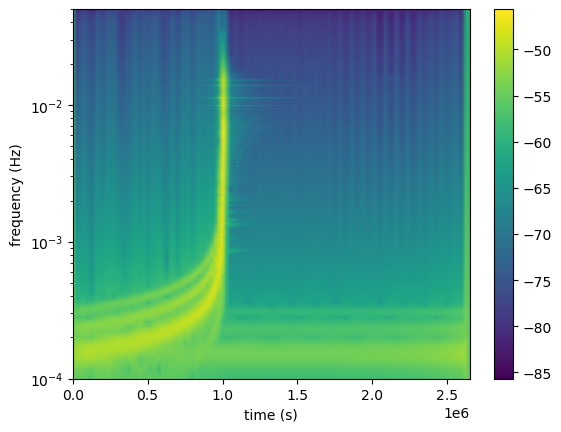

In [10]:
def plot_spectogram(
        signal,
        dt,
        max_frequency = 0.1,
        min_frequency = 0.0001):

    f_mesh, t_mesh, sig_Z = sp.signal.stft(signal, 1/dt, nperseg=50000/dt)
    max_frequency_index = np.searchsorted(f_mesh, max_frequency)
    min_frequency_index = np.searchsorted(f_mesh, min_frequency)

    plt.figure()
    plt.pcolormesh(t_mesh, f_mesh[min_frequency_index:max_frequency_index], np.log(np.abs(sig_Z[min_frequency_index:max_frequency_index])), shading='gouraud')
    plt.colorbar()
    plt.xlabel('time (s)')
    plt.ylabel('frequency (Hz)')
    plt.yscale('log')

wave_time_domain = np.fft.irfft(AET[0], axis=-1)

plot_spectogram(wave_time_domain[1], dt)

## Task 3: Inject an MBHB and compute its SNR

Now we will combine our knowledge of `lisatools` with `bbhx`. Using the same methods above, setup a full `AnalysisContainer` and inject an MBHB signal. Calculate its SNR. 

In [11]:
from lisatools.sensitivity import AET1SensitivityMatrix
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer

In [12]:
# Bruhhh this is literally just to use the tdi_wave_gen object of the BBHWaveformFD class
# The only reason for doing this is to have *args, **kwargs as the input. Notice the [0] at the end of the return statement.
def wrap(*args, **kwargs):
    return tdi_wave_gen(*args, **kwargs)[0]

In [17]:
# AET[0] because AET.shape = (1, 3, len(freqs)). Get rid of that useless dimension by using [0].
data = DataResidualArray(AET[0], f_arr=freqs)

# I'm pretty sure AET1SensitivityMatrix(data.f_arr) is the same as SensitivityMatrix(data.f_arr, ['A1TDISens', 'E1TDISens', 'T1TDISens']). This is just convenient.
sens_mat = AET1SensitivityMatrix(data.f_arr)

# 
analysis = AnalysisContainer(data_res_arr=data, 
                             sens_mat=sens_mat, 
                             signal_gen=wrap)

# signal_gen = Callable object that takes INFORMATION THROUGH *ARGS AND **KWARGS 
# and generates a signal in the proper channel setup employed in data_res_arr and sens_mat (AET in our case).

In [18]:
# This snr is the ratio of the SIGNAL in data_res_arr (injected gw signal) TO the NOISE in the sens_mat object.
analysis.snr()

3121.443697068461

Calculate the Likelihood using `calculate_signal_likelihood`. It returns the likelihood of a generated signal with the data.

In [28]:
analysis.calculate_signal_likelihood(
    m1 * 1.1,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=freqs
    ),
    source_only=True,
    #data_arr_kwargs=dict(f_arr=freqs)
)

np.float64(-3212907.363095356)

## Task 4: MCMC with MBHBs

Now we will run an MCMC for MBHBs. Use your knowledge from our tutorial on `Eryn` to run an MCMC for MBHBs. Let's run it for over four parameters: `(mT, q, phi_ref, t_ref)`. You can use an `Eryn` [TransformContainer](https://mikekatz04.github.io/Eryn/html/user/utils.html#transformcontainer) or a wrapper Likelihood to fill in fixed parameters and make necessary transformations. **Remember**: the waveform generator takes `m1` and `m2`, so you will need to transform these inside the Likelihood function. You can use the `periodic` kwarg for `EnsembleSampler` to run `phi_ref` as a periodic variable wrapping over the edge.

This will not be fast. Run the sampler for a small number of samples and move on to the next step. 

mT = m1 + m2 = Total Mass 

q  = m2 / m1 = Mass Ratio

In [18]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

In [19]:
# clear (for internal clearing of answers)
 
def wrapper_likelihood(x, fixed_parameters, freqs, analysis, **kwargs):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = analysis.calculate_signal_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
            length=1024, 
            combine=False,  # TODO: check this
            direct=False,
            fill=True,
            squeeze=True,
            freqs=freqs
        ),
        source_only=True
        # data_arr_kwargs=dict(f_arr=freqs)
    )
    return ll

In [20]:
# clear (for internal clearing of answers)
 
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(1e5, 5e6),
    1: uniform_dist(0.05, 0.999999),
    2: uniform_dist(0.0, 2 * np.pi),
    3: uniform_dist(0.0, Tobs + 24 * 3600.0),
})}

injection_params = np.array([
    m1 + m2,
    m2 / m1,
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref
])

fixed_parameters = np.array([
    chi1,
    chi2,
    dist, 
    f_ref, 
    inc,
    lam,
    beta,
    psi,
])

periodic = {"mbh": {2: 2 * np.pi}}

ntemps = 10
nwalkers = 32
ndims = {"mbh": 4}
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
    periodic=periodic
)

In [21]:
# clear (for internal clearing of answers)
 
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))
start_state = State({"mbh": start_params})
sampler.compute_log_prior(start_state.branches_coords)
sampler.run_mcmc(start_state, 10, progress=True)

100%|██████████| 10/10 [05:03<00:00, 30.37s/it]


## Task 5: Add heterodyning for speed

That would take a long time to complete a sampling run. One technique for speeding up waveforms is called `heterodyning`. Wrap the Heterodyned likelihood to use a subset of parameters. You can also use an Eryn `TransformFunction`. 

Useful Documentation:

* [HeterodynedLikelihood](https://mikekatz04.github.io/BBHx/html/user/like.html#bbhx.likelihood.HeterodynedLikelihood)

In [22]:
# imports
from bbhx.likelihood import HeterodynedLikelihood

No CuPy


In [23]:
# clear (for internal clearing of answers)
 
# how many frequencies to use
length_f_het = 128

mT = injection_params[0]
q = injection_params[1]

transformed_injection_params = injection_params.copy()
transformed_injection_params[0] = mT / (1 + q)
transformed_injection_params[1] = mT * q / (1 + q)
# initialize Likelihood
like_het = HeterodynedLikelihood(
    tdi_wave_gen,
    freqs,
    data[:],
    transformed_injection_params,
    length_f_het,
)

like_het.get_ll(transformed_injection_params[None, :].T)

array([-0.0008215])

In [24]:
# clear (for internal clearing of answers)
 
def het_wrapper_likelihood(x, fixed_parameters, freqs, het_like):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)

    # 
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = like_het.get_ll(all_parameters)
    return ll

In [25]:
# clear (for internal clearing of answers)
 
ll_comp = wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, analysis)
ll_het = het_wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, like_het)
print(ll_het, ll_comp)

[-0.0008215] 1.862645149230957e-09


In [26]:
# clear (for internal clearing of answers)
 
nwalkers = 32
het_sampler = EnsembleSampler(
    nwalkers,
    ndims,
    het_wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, like_het),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    periodic=periodic
)

In [27]:
# clear (for internal clearing of answers)
 
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-1 * np.random.randn(ntemps, nwalkers, 1, 4))
start_params[:, :, :, 2] %= (2 * np.pi)
het_start_state = State({"mbh": start_params})
het_sampler.backend.reset(*het_sampler.backend.reset_args,**het_sampler.backend.reset_kwargs)
het_sampler.run_mcmc(het_start_state, 1000, burn=200, progress=True)

100%|██████████| 1000/1000 [03:05<00:00,  5.40it/s]


Parameter mT in chain An Example Contour is not constrained
Parameter q in chain An Example Contour is not constrained
Parameter t_ref in chain An Example Contour is not constrained


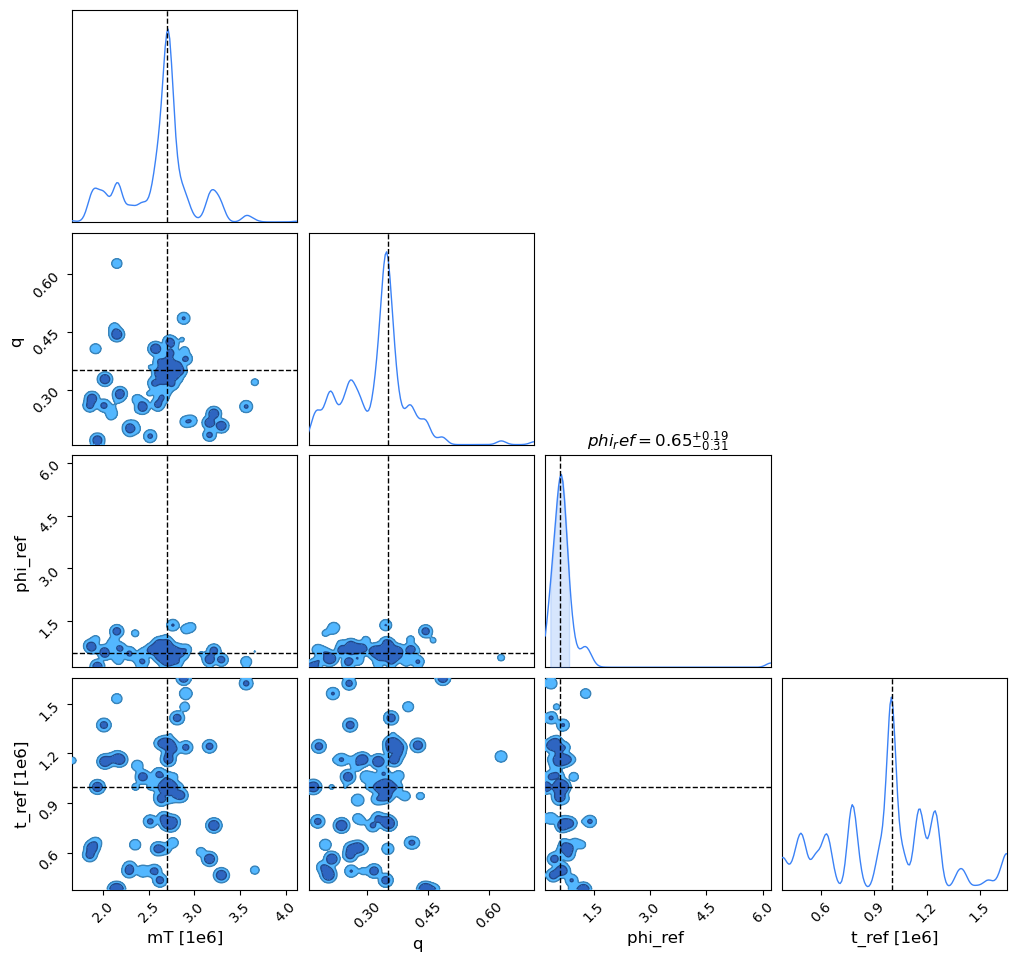

In [28]:
# clear (for internal clearing of answers)
 
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd
samples = het_sampler.get_chain()["mbh"][:, 0].reshape(-1, 4)
df = pd.DataFrame(samples, columns=["mT", "q", "phi_ref", "t_ref"])
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
c.add_truth(Truth(location={"mT": injection_params_sub[0], "q": injection_params_sub[1], "phi_ref": injection_params_sub[2], "t_ref": injection_params_sub[3]}))
fig = c.plotter.plot()

Let's check how well the heterodyning method matches the base likelihood by sampling our prior. You will have to update the reference template for each computation since we are drawing from the prior and may be far away from our true point. You can do this with `HeterodynedLikelihood.init_heterdyne_info`. **Warning**: if you run this next box, it may complicate the above calculations, so be careful the order you run things. This is one reason why I always develop with scripts and the terminal (and often VScode) rather than jupyter notebook.

In [29]:
# clear (for internal clearing of answers)
 
num = 10
for params in priors["mbh"].rvs(num):
    update_params = injection_params.copy()
    mT = params[0]
    q = params[1]
    m1 = mT / (1 + q)
    m2 = mT * q / (1 + q)
    update_params[np.array([0, 1, 5, 11])] = np.array([m1, m2, params[2], params[3]])
    like_het.init_heterodyne_info(
        update_params
    )
    ll_comp = wrapper_likelihood(params, fixed_parameters, freqs, analysis)
    ll_het = het_wrapper_likelihood(params, fixed_parameters, freqs, like_het)
    print(ll_comp, ll_het, np.abs(ll_comp - ll_het), np.abs(ll_comp - ll_het) / np.abs(ll_comp))

-19086857.493384168 [-19086857.51868594] [0.02530177] [1.32561211e-09]
-5223994.590792505 [-5223985.95837618] [8.63241633] [1.65245507e-06]
-8981987.460641278 [-8981978.63733686] [8.82330442] [9.82333193e-07]
-18352422.258475196 [-18352414.060942] [8.1975332] [4.46673092e-07]
-8407607.194762804 [-8407575.08590092] [32.10886189] [3.81902498e-06]
-5542293.98553797 [-5542285.81138376] [8.17415421] [1.47486839e-06]
-6748517.671823792 [-6748508.98451243] [8.68731137] [1.28729179e-06]
-4910909.166235 [-4905930.59001409] [4978.57622091] [0.00101378]
-20360168.872993432 [-20339228.49055742] [20940.38243601] [0.0010285]
-5446909.563377029 [-5441465.11655502] [5444.44682201] [0.00099955]
